In [17]:
import flatten_lattice as fl
import torch
from bert_models import LinearLatticeBert, LinearPOSBert
from encoding_utils import *

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [ ]:
resarrs = []
fl.get_allcands(fl.frenbase, -1, resarrs)
""

In [ ]:
processedgraphs = fl.get_processed_graph_data(fl.frenbase, -1, 1)

In [11]:
for r in range(0, len(resarrs)):
    try:
        if len(resarrs[r])==0:
            print(r)
            del resarrs[r]
            del processedgraphs[r]
    except:
        break
print(len(resarrs))
print(len(processedgraphs))
bert_tok = fl.bert_tok
mbart_tok = fl.mbart_tok

99
99


In [13]:
p = processedgraphs[17]
tlist = fl.get_toklist(p)
decstr = bert_tok.decode(tlist)
print(len(tlist))
#for node in p:
    #print(node['token_idx'], " ", node['pos'])
print(decstr)
#"[CLS] The NSA case underlines the complete lack of discussion on intelligence. debate over intelligence. about intelligence. on intelligence. intelligence discussion. debate. total absence of any debate on intelligence. intelligence debate. a debate on an intelligence debate. debate over intelligence. about intelligence. on intelligence discussion. lack of discussion on intelligence. debate over about scores the complete lack absence of any a an debate over about total lack highlights complete lack of debate on a complete lack of total absence of debate on intelligence discussion. lack of debate the complete lack total lack NSA underlines total lack ofscores total lack of highlights the total lack of complete absence of debate total [SEP]"

27
Antibodies trace all nicotine molecules found in the blood system and neutralize them before they reach the brain., detect track


In [ ]:
posbmodel = LinearPOSBert(52)
posbmodel.load_state_dict(torch.load("./posbert/posbertmodel/posbert.pth"))
posbmodel.eval()
print(torch.cuda.memory_allocated("cuda:2"))

In [50]:
def prepare_dataset(resset):
    x = []
    y = []
    for res in resset:
        curinps = []
        for r in res:
            try:
                toktmp = torch.tensor(bert_tok(clean_expanded(r)).input_ids)
                #print(toktmp.shape)
                if float(toktmp.shape[0])<MAX_LEN:
                    toktmp = torch.cat([toktmp, torch.zeros(MAX_LEN-toktmp.shape[0])])
                else:
                    toktmp = toktmp[:MAX_LEN]
                curinps.append(toktmp)
            except:
                print("weird error happened") 
        print(len(curinps))
        curouts = []
        tinp = torch.stack(curinps).long().to(device)
        print(tinp.shape)
        y.append(posbmodel(tinp))
        x.append(tinp)
        
        #print("error somewhere")
    return x, y

def get_labset_partial(explodeds, startind, amt):
    #print(torch.cuda.memory_allocated("cuda:2"))
    dsetx, dsety = prepare_dataset(explodeds[startind:startind+amt])
    print(len(dsetx))
    #print(torch.cuda.memory_allocated("cuda:2"))
    assert len(dsetx)==amt
    latposylabels = lattice_pos_goldlabels(dsetx, dsety, sents[startind:startind+amt])
    #print(torch.cuda.memory_allocated("cuda:2"))
    del dsetx, dsety
    
    torch.cuda.empty_cache()
    #print(torch.cuda.memory_allocated("cuda:2"))
    return latposylabels

def get_biglabset(split):
    result = None
    for i in range(0, int(len(resarrs)/split)):
        print("SUBSET - ", i)
        try:
            if result ==None:
                result = get_labset_partial(resarrs, i*split, split)
            else:
                result = torch.cat((result, get_labset_partial(resarrs, i*split, split)))
        except:
            print("empty list")
        torch.cuda.empty_cache()
        torch.save(result, './plabels/latsmallposlabels.pt')
    return result

In [61]:
sents, posids = create_inputs(processedgraphs)
print(torch.cuda.memory_allocated("cuda:2"))
torch.cuda.empty_cache()

#with torch.no_grad():
    #latposylabels = get_biglabset(1)
latposylabels = torch.load('latposlabelsdone.pt').to(device)

In [62]:
pred = posbmodel(sents, posids)

In [18]:
torch.sum(soft(latposylabels)[0][0])

NameError: name 'latposylabels' is not defined

In [93]:
r1 = torch.rand((6, 500, 52))
r2 = torch.rand((6, 500, 52))

In [118]:
mse(r1, r2)

tensor(0.1668)

In [110]:
loss(r1, r2)

tensor(0.7338)

In [67]:
pred.shape

torch.Size([99, 500, 52])

In [31]:
mse(latposylabels, pred)

tensor(35.8972, device='cuda:2', grad_fn=<MseLossBackward0>)

In [65]:
def check_accuracy(setpred, setlabels):
    cor = 0
    tot = 0
    for i in range(0, len(setpred)):
        ex = setpred[i]
        for j in range(0, len(ex)):
            if sum(setlabels[i][j])==0:
                continue
            tot+=1
            if torch.argmax(ex[j])==torch.argmax(setlabels[i][j]):
                cor+=1
    return cor/tot

def check_randacc(setpred, setlabels):
    cor = 0
    tot = 0
    for i in range(0, len(setpred)):
        ex = setpred[i]
        for j in range(0, len(ex)):
            if sum(setlabels[i][j])==0:
                continue
            tot+=1
            if torch.argmax(torch.rand(52).to(device))==torch.argmax(setlabels[i][j]):
                cor+=1
    return cor/tot
            
print(check_accuracy(pred, latposylabels))
print(check_randacc(pred, latposylabels))

0.09654730135087611
0.018122013281201513


In [32]:
from scipy.spatial.distance import cosine
from more_itertools import locate

def ind_cos_dist (i1, i2, embed):
    return 1-cosine(embed[i1].cpu(), embed[i2].cpu())

def tok_cos_dist(embed1, embed2, inps1, inps2, tok):
    l1 = list(inps1)
    l2 = list(inps2)
    
    inds1 = find_indices(l1, tok)
    inds2 = find_indices(l2, tok)
    sims = []
    e1 = embed1.cpu()
    e2 = embed2.cpu()
    for i1 in inds1:
        for i2 in inds2:
            sims.append(1-cosine(e1[i1], e2[i2]))
    #assert l1[ind1]==l2[ind2]
    return sims

def tok_cos_notbase(embed1, embed2, inps1, inps2, tok):
    l1 = list(inps1)
    l2 = list(inps2)
    
    inds1 = find_indices(l1, tok)
    inds2 = find_indices(l2, tok)
    sims = []
    e1 = embed1.cpu()
    e2 = embed2.cpu()
    for i1 in range(0, len(inps1)):
        for i2 in range(0, len(inps2)):
            if inps1[i1]==inps2[i2]:
                continue
            sims.append(1-cosine(e1[i1], e2[i2]))
    return sims



In [13]:
#latbert = LinearLatticeBert(52)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
#basebert = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
import matplotlib.pyplot as plt

def mean(lis):
    try:
        return sum(lis)/len(lis)
    except:
        return 0.8

def get_ex_distr(example, ex_cand, latembed=None, sents=None):
    if latembed == None:
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
    norm_inputs = torch.tensor([bert_tok(clean_expanded(resarrs[example][ex_cand])).input_ids])
    #norm_inputs
    with torch.no_grad():
        norm_out = basebert(input_ids=norm_inputs, return_dict=True, output_hidden_states=True)
    normembed = norm_out['last_hidden_state'][0]
    res = []
    for r in norm_inputs[0]:
        res.append(mean(tok_cos_dist(latembed, normembed, sents[0], norm_inputs[0], r)))
    
    return res

def get_ex_notbase(example, ex_cand, latembed=None, sents=None):
    if latembed == None:
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
    norm_inputs = torch.tensor([bert_tok(clean_expanded(resarrs[ex_cand][0])).input_ids])
    #norm_inputs
    with torch.no_grad():
        norm_out = basebert(input_ids=norm_inputs, return_dict=True, output_hidden_states=True)
    normembed = norm_out['last_hidden_state'][0]
    res = []
    res.append(mean(tok_cos_notbase(latembed, normembed, sents[0], norm_inputs[0], r)))
    
    return res

def get_diff_base(latembed, inp_toks):
    diff = []
    for i in range(len(inp_toks)):
        for j in range(len(inp_toks)):
            if inp_toks[i]==inp_toks[j]:
                diff.append(ind_cos_dist(i, j, latembed))
            
    return diff

def get_lat_distr(example):
    result = []
    tot = len(resarrs[example])
    if tot>100:
        tot = 100
    for i in range(tot):
        print(i)
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
        result.append(mean(get_ex_distr(example, i, latembed, sents)))
    print(len(resarrs[example]))
    return result

(array([  8.,  10.,   0.,  30.,  30.,  64.,  92., 110., 254., 518.]),
 array([0.68519515, 0.71667563, 0.74815612, 0.7796366 , 0.81111709,
        0.84259757, 0.87407806, 0.90555854, 0.93703903, 0.96851951,
        1.        ]),
 <BarContainer object of 10 artists>)

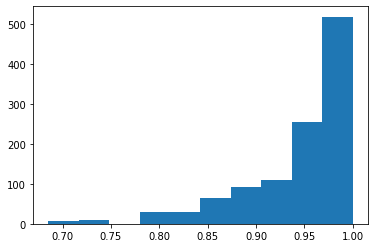

In [66]:
sents, posids = create_inputs(processedgraphs[0:0+1])
out = latbert(sents, posids)
latembed = out['last_hidden_state'][0]
plt.hist(get_diff_base(latembed, sents[0]))

In [96]:
res = []

get_ex_notbase(0, 5)


[0.4216383578272023]

In [ ]:
plt.hist(res, bins = 2)

In [35]:
res[9]

[0.719793975353241,
 0.7008659243583679,
 0.6701750755310059,
 0.6903993487358093,
 0.6903993487358093]

In [29]:
print(norm_inputs)
print(sents)

tensor([[ 101,  146, 1341, 1175, 1132, 1160, 3001, 1104, 2593, 1113, 1103, 1226,
         1104, 1103, 1497, 2384,  112,  188, 2593,  119,  102]])
tensor([[ 101,  146, 1341, 1175, 1132, 1160, 3001, 1104, 2593, 1118, 1103, 1497,
         2384,  119,  119, 1113, 1103, 1226, 1104, 1103, 1497, 2384,  119,  112,
          188, 2593,  119, 1121, 1103, 1497, 2384, 2059, 1175, 1132, 1160, 1115,
         1175, 1132, 1160, 3001, 1104, 2593, 1118, 1103, 1497, 2384,  119,  119,
         1113, 1103, 1226, 1104, 1103, 1497, 2384,  119, 1121, 1103, 1497, 2384,
         1130, 1139, 2458, 1175, 1132, 1160,  117, 1103, 1497, 2384, 1144, 5133,
         1120, 1160, 3001,  119, 1160, 3001,  119, 1104, 2593, 1106, 1142, 1121,
         1103, 2827,  119, 1118, 1103, 1497, 2384,  119,  119, 1113, 1103, 1497,
         2384,  119,  787,  188, 1226,  119,  112,  188, 1226,  119, 1226, 1104,
         1103, 2384,  119, 1104, 1699,  119, 1497, 3912,  119, 2384,  131,  119,
         1121, 1103, 2384,  119, 1104, 1699,

In [2]:
# Importing the relevant modules
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

device = "cuda:2"
# Loading the pre-trained BERT model
###################################
# Embeddings will be derived from
# the outputs of this model
model = BertModel.from_pretrained('bert-base-cased',
           output_hidden_states = True,).to(device)
# Setting up the tokenizer
###################################
# This is the same tokenizer that
# was used in the model to generate
# embeddings to ensure consistency
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

2022-08-15 07:46:29.695833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 07:46:29.695855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

In [10]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    return tokenized_text, tokens_tensor, segments_tensors

def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings


In [13]:
target_word_embeddings = []

for text in examples:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    
    # Find the position 'bank' in list of tokens
    word_index = tokenized_text.index('Obama')
    # Get the embedding for bank
    word_embedding = list_token_embeddings[word_index]

    target_word_embeddings.append(word_embedding)

In [17]:
len(target_word_embeddings[0])

768

In [107]:
bert_model = LinearLatticeBert(52)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [119]:
sents = torch.tensor(sents).to(device)
posids = torch.tensor(posids).to(device)

In [120]:
out = bert_model(sents, posids)

In [126]:

lhs = out['last_hidden_state'][0]

In [139]:
list(sents[0])[14]

tensor(119, device='cuda:2')

In [155]:
ind_cos_dist(13, 14, lhs)

1.0

In [171]:
inptest = bert_tok(clean_expanded(resarrs[0][1]))

In [169]:
normal_bert = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [180]:
normalout = normal_bert(torch.tensor([inptest.input_ids]),return_dict=True, output_hidden_states=True)
normalhs = normalout['last_hidden_state'][0]

In [175]:
bert_tok(clean_expanded(resarrs[0][1]))

{'input_ids': [101, 1109, 27020, 1692, 1223, 10443, 1103, 2335, 2960, 1104, 6145, 1113, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [183]:
tok_cos_dist(lhs,normalhs,  1109)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous